In [1]:
from AD_analysis import *
import Atmospheric_diffraction as atm_shift


WAVELENGTH vs DISPLACEMENT for VARIOUS AIRMASSES, AND DISPLACEMENT vs AIRMASS for VARIOUS WAVELENGTHS

HA used
Target goes below Horizon above/below HA of +/- 5.7h
[34.6272     37.59315339 45.33753609 55.89851346]


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/Users/Jay.Stephan/Library/CloudStorage/OneDrive-ScienceandTechnologyFacilitiesCouncil/Documents/Work/MOSAIC/AD/AD-Code/Version 2/Atmospheric_diffraction.py:114: RuntimeWarning: invalid value encountered in arccos
  HA = np.arccos((np.sin(alt)-np.sin(lat)*np.sin(dec))/(np.cos(lat)*np.cos(dec)))


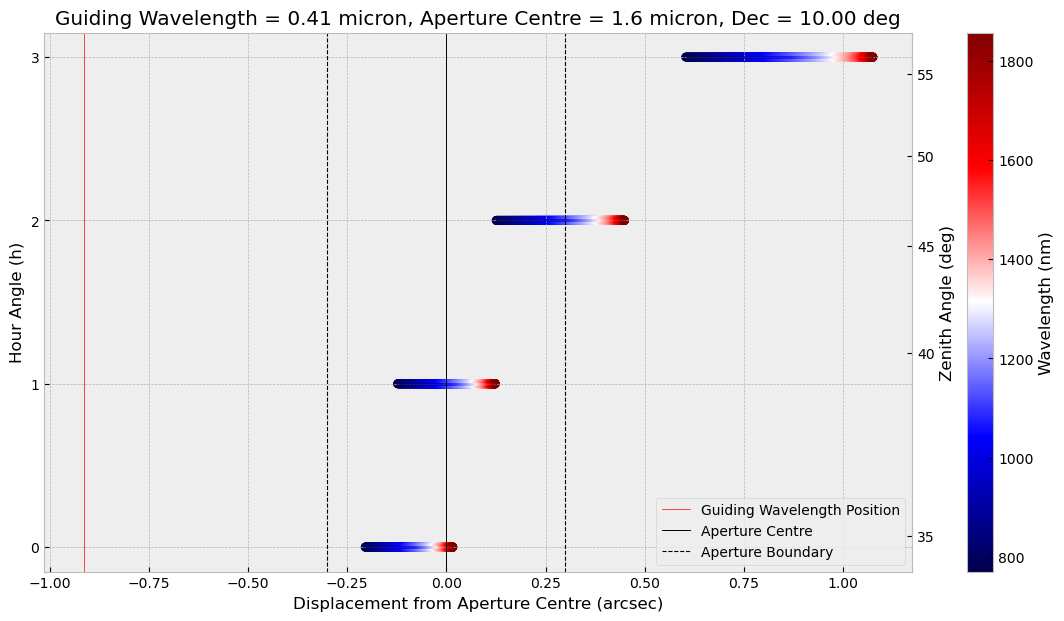

In [39]:
#HA PLOTS:
def shift_plot(input_parameters,output_parameters,conditions):

    HA_range=input_parameters['HA_range']
    HA_to_ZA_range=atm_diff.HA_2_ZA(HA_range,input_parameters['targ_dec'])
    print(HA_to_ZA_range)

    centre_shift=atm_diff.diff_shift(input_parameters['fibrecentre_waveref'],output_parameters['airmasses'][0],input_parameters['guide_waveref'],conditions)
    T_arc = lambda T_mm: T_mm * analysis.plate_scale
    T_mm = lambda T_arc: T_arc / analysis.plate_scale


    to_HA = lambda ZA_vals: atm_diff.ZA_2_HA(ZA_vals,input_parameters['targ_dec'])
    to_ZA = lambda HA_vals: atm_diff.HA_2_ZA(HA_vals,input_parameters['targ_dec'])
    fig, ax = plt.subplots(figsize=(14,7))
    ax2 = ax.secondary_yaxis("right", functions=(to_ZA, to_HA))
    if input_parameters['reposition'] == False: #If repositioned, wavelength reference centre is meaningless as relative position changes
        plt.axvline(-centre_shift.value,linewidth=0.5,color='red',label='Guiding Wavelength Position')
    xvals=np.linspace(-1,1,len(output_parameters['wave_wavelengths']))
    c=np.tan(xvals)
    for i in range(0,len(output_parameters['shifts'])):
        yvals=np.full(len(output_parameters['shifts'][i]),HA_range[i])
        plt.scatter(output_parameters['shifts'][i],yvals,c=c,cmap='seismic')
        norm = plt.Normalize(output_parameters['wave_wavelengths'].value.min(), output_parameters['wave_wavelengths'].value.max())
        points = np.array([output_parameters['shifts'][i], yvals]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='seismic', norm=norm)
        lc.set_array(output_parameters['wave_wavelengths'].value)
        lc.set_linewidth(2)
        line=ax.add_collection(lc)
    fig.colorbar(line, label='Wavelength (nm)')
    plt.axvline(0,linewidth=0.7,color='black',label='Aperture Centre')
    plt.axvline(output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',label='Aperture Boundary',linestyle='--')
    plt.axvline(-output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',linestyle='--')
    plt.xlabel('Displacement from Aperture Centre (arcsec)')
    plt.ylabel('Hour Angle (h)')
    ax2.set_ylabel("Zenith Angle (deg)")
    plt.yticks(np.linspace(min(HA_range),max(HA_range),len(HA_range)))
    plt.legend()
    plt.title('Guiding Wavelength = %s, Aperture Centre = %s, Dec = %2.2f deg' %(input_parameters['guide_waveref'],input_parameters['fibrecentre_waveref'],input_parameters['targ_dec'].value))    

    plt.savefig("graphs/NIR_Displacement.png",dpi=500)   
    
analysis=AD_analysis()
analysis.load_airmasses(HA_range=[0,1,2,3],targ_dec=10 * u.deg)
analysis.load_wave("LR","NIR","IY","H",sampling=1*u.nm)
analysis.calculate_shifts(fibrecentre_waveref = 1.6 * u.micron,reposition=False,guide_waveref=0.41*u.micron)
input_parameters=analysis.input_parameters
output_parameters=analysis.output_parameters
conditions=analysis.conditions
shift_plot(input_parameters,output_parameters,conditions)

In [40]:
#HA PLOTS:
def shift_plot(input_parameters,output_parameters,conditions):
    if input_parameters['HA_range'] != []: #If plot is True and HA values are used, plot the 2 graphs
        HA_range=input_parameters['HA_range']
        HA_to_ZA_range=atm_diff.HA_2_ZA(HA_range,input_parameters['targ_dec'])
        print(HA_to_ZA_range)
        #1) wavelength vs displacement for different HA 
        centre_shift=atm_diff.diff_shift(input_parameters['fibrecentre_waveref'],output_parameters['airmasses'][0],input_parameters['guide_waveref'],conditions)
        T_arc = lambda T_mm: T_mm * analysis.plate_scale
        T_mm = lambda T_arc: T_arc / analysis.plate_scale
        fig, ax = plt.subplots(figsize=(10,7))
        ax2 = ax.secondary_yaxis("right", functions=(T_arc, T_mm))
        if input_parameters['reposition'] == False: #If repositioned, wavelength reference centre is meaningless as relative position changes
            plt.axhline(-centre_shift.value,linewidth=0.5,color='red', label='Wavelength Reference Centre')
        for i in range(0,len(output_parameters['airmasses'])):
            plt.plot(output_parameters['wave_wavelengths'],output_parameters['shifts'][i],label="HA = %2.2fh" %(HA_range[i]))
        plt.axhline(0,linewidth=0.8,color='black',label='Fibre Centre')
        plt.axhline(output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',label='Fibre Boundary',linestyle='--')
        plt.axhline(-output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',linestyle='--')
        plt.title('Wavelength Reference %s, Fibre Centre on %s, Dec = %2.2f deg' %(input_parameters['guide_waveref'],input_parameters['fibrecentre_waveref'],input_parameters['targ_dec'].value))
        plt.legend(loc='best')

        ax.set_ylabel('Displacement from Fibre Centre (arcsec)')
        ax2.set_ylabel('Displacement from Fibre Centre (mm)')
        ax.set_xlabel('Wavelength (nm)')

        #2) Displacement vs HA for different wavelengths
        to_HA = lambda ZA_vals: atm_diff.ZA_2_HA(ZA_vals,input_parameters['targ_dec'])
        to_ZA = lambda HA_vals: atm_diff.HA_2_ZA(HA_vals,input_parameters['targ_dec'])
        fig, ax = plt.subplots(figsize=(12,7))
        ax2 = ax.secondary_yaxis("right", functions=(to_ZA, to_HA))
        if input_parameters['reposition'] == False: #If repositioned, wavelength reference centre is meaningless as relative position changes
            plt.axvline(-centre_shift.value,linewidth=0.5,color='red',label='Guiding Reference')
        xvals=np.linspace(-1,1,len(output_parameters['wave_wavelengths']))
        c=np.tan(xvals)
        for i in range(0,len(output_parameters['shifts'])):
            yvals=np.full(len(output_parameters['shifts'][i]),HA_range[i])
            plt.scatter(output_parameters['shifts'][i],yvals,c=c)
            norm = plt.Normalize(output_parameters['wave_wavelengths'].value.min(), output_parameters['wave_wavelengths'].value.max())
            points = np.array([output_parameters['shifts'][i], yvals]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, cmap='viridis', norm=norm)
            lc.set_array(output_parameters['wave_wavelengths'].value)
            lc.set_linewidth(2)
            line=ax.add_collection(lc)
        fig.colorbar(line)
        plt.axvline(0,linewidth=0.7,color='black',label='Aperture Centre')
        plt.axvline(output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',label='Aperture Boundary',linestyle='--')
        plt.axvline(-output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',linestyle='--')
        plt.xlabel('Displacement from Aperture Centre (arcsec)')
        plt.ylabel('Hour Angle (h)')
        ax2.set_ylabel("Zenith Angle (deg)")
        plt.yticks(np.linspace(min(HA_range),max(HA_range),len(HA_range)))
        plt.legend()
        plt.title('Guiding Reference = %s, Aperture Centre = %s, Dec = %2.2f deg' %(input_parameters['guide_waveref'],input_parameters['fibrecentre_waveref'],input_parameters['targ_dec'].value))    

        plt.savefig("Displacement.png",dpi=500)    

    #ZA PLOTS
    if input_parameters['ZA_range'] != []: #If plot is True and Zenith Angle values are used, plot the 2 graphs
        ZA_range=input_parameters['ZA_range']

        #1) wavelength vs displacement for different HA 
        centre_shift=atm_diff.diff_shift(input_parameters['fibrecentre_waveref'],output_parameters['airmasses'][0],input_parameters['guide_waveref'],conditions)
        T_arc = lambda T_mm: T_mm * analysis.plate_scale
        T_mm = lambda T_arc: T_arc / analysis.plate_scale
        fig, ax = plt.subplots(figsize=(10,7))
        ax2 = ax.secondary_yaxis("right", functions=(T_arc, T_mm))
        if input_parameters['reposition'] == False: #If repositioned, wavelength reference centre is meaningless as relative position changes
            plt.axhline(-centre_shift.value,linewidth=0.5,color='red', label='Wavelength Reference Centre')
        for i in range(0,len(output_parameters['airmasses'])):
            plt.plot(output_parameters['wave_wavelengths'],output_parameters['shifts'][i],label="ZA = %2.2f deg" %(ZA_range[i]))
        plt.axhline(0,linewidth=0.8,color='black',label='Fibre Centre')
        plt.axhline(output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',label='Fibre Boundary',linestyle='--')
        plt.axhline(-output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',linestyle='--')
        plt.legend(loc='best')
        ax.set_ylabel('Displacement from Fibre Centre (arcsec)')
        ax2.set_ylabel('Displacement from Fibre Centre (mm)')
        ax.set_xlabel('Wavelength (nm)')
        plt.title('Guiding Reference = %s, Aperture Reference = %s' %(input_parameters['guide_waveref'],input_parameters['fibrecentre_waveref']))


        #2) Displacement vs ZA for different wavelengths
        fig, ax = plt.subplots(figsize=(10,7))

        if input_parameters['reposition'] == False: #If repositioned, wavelength reference centre is meaningless as relative position changes
            plt.axvline(-centre_shift.value,linewidth=0.5,color='red',label='Wavelength Reference Centre')
        xvals=np.linspace(-1,1,len(output_parameters['wave_wavelengths']))
        c=np.tan(xvals)
        for i in range(0,len(output_parameters['shifts'])):
            yvals=np.full(len(output_parameters['shifts'][i]),ZA_range[i])
            plt.scatter(output_parameters['shifts'][i],yvals,c=c)
            norm = plt.Normalize(output_parameters['wave_wavelengths'].value.min(), output_parameters['wave_wavelengths'].value.max())
            points = np.array([output_parameters['shifts'][i], yvals]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, cmap='viridis', norm=norm)
            lc.set_array(output_parameters['wave_wavelengths'].value)
            lc.set_linewidth(2)
            line=ax.add_collection(lc)
        fig.colorbar(line)
        plt.axvline(0,linewidth=0.8,color='black',label='Fibre Centre')
        plt.axvline(output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',label='Fibre Boundary',linestyle='--')
        plt.axvline(-output_parameters['fibre_diameter'].value/2,linewidth=0.8,color='black',linestyle='--')
        plt.xlabel('Displacement from Fibre Centre (arcsec)')
        plt.ylabel('Zenith Angle (deg)')
        plt.yticks(np.linspace(min(ZA_range),max(ZA_range),len(ZA_range)))
        plt.legend()
        plt.title('Guiding Reference = %s, Aperture Reference = %s' %(input_parameters['guide_waveref'],input_parameters['fibrecentre_waveref']))
    

HA used
Target goes below Horizon above/below HA of +/- 5.7h
[34.6272     37.59315339 45.33753609 55.89851346]


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


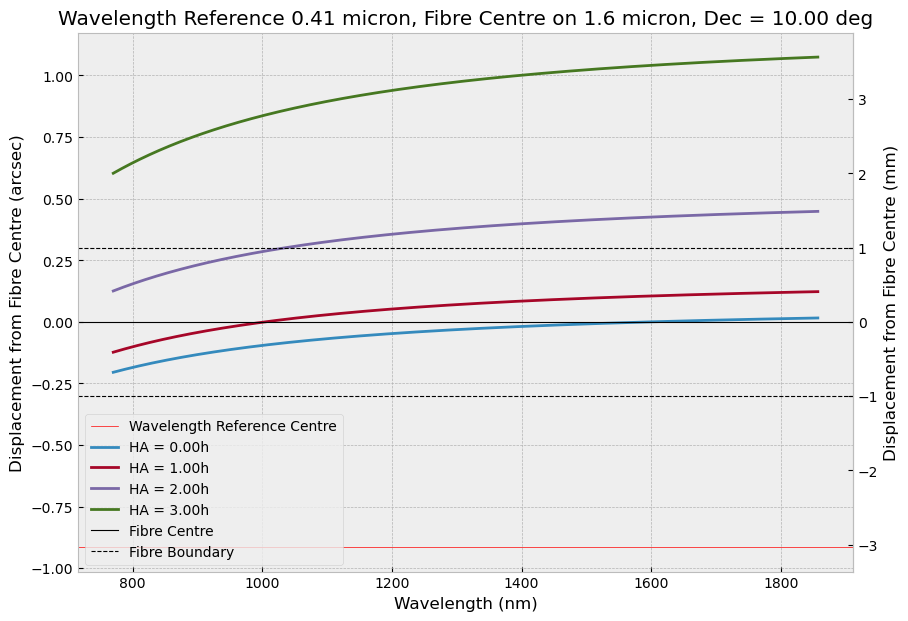

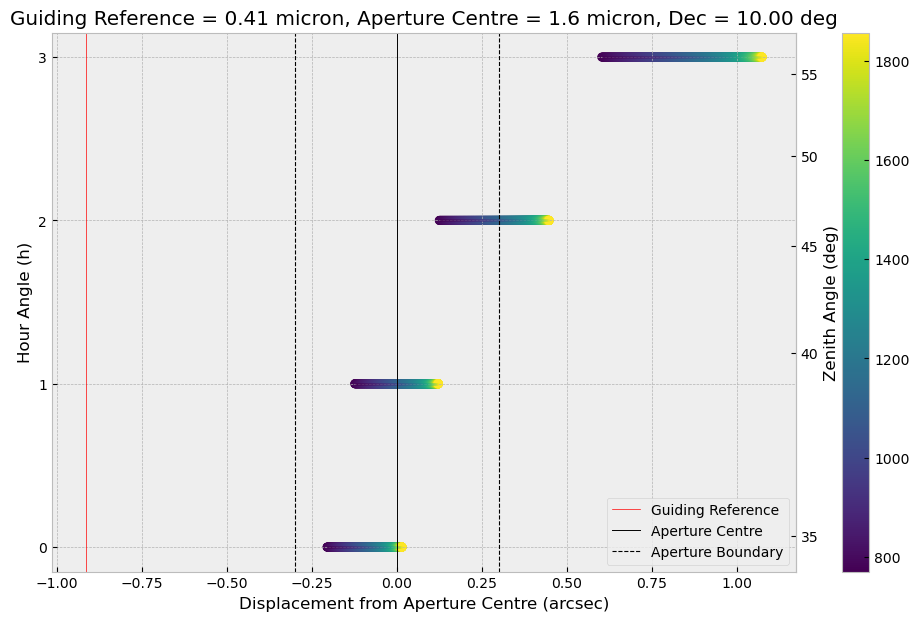

In [4]:
analysis=AD_analysis()
analysis.load_airmasses(HA_range=[0,1,2,3],targ_dec=10 * u.deg)
analysis.load_wave("LR","NIR","IY","H",sampling=1*u.nm)
analysis.calculate_shifts(fibrecentre_waveref = 1.6 * u.micron,reposition=False,guide_waveref=0.41*u.micron)
input_parameters=analysis.input_parameters
output_parameters=analysis.output_parameters
conditions=analysis.conditions
shift_plot(input_parameters,output_parameters,conditions)

Zenith Angles Used
1030
Movement of NIR Fibre Centre from Start to End = 0.49992584117896965 arcsec


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


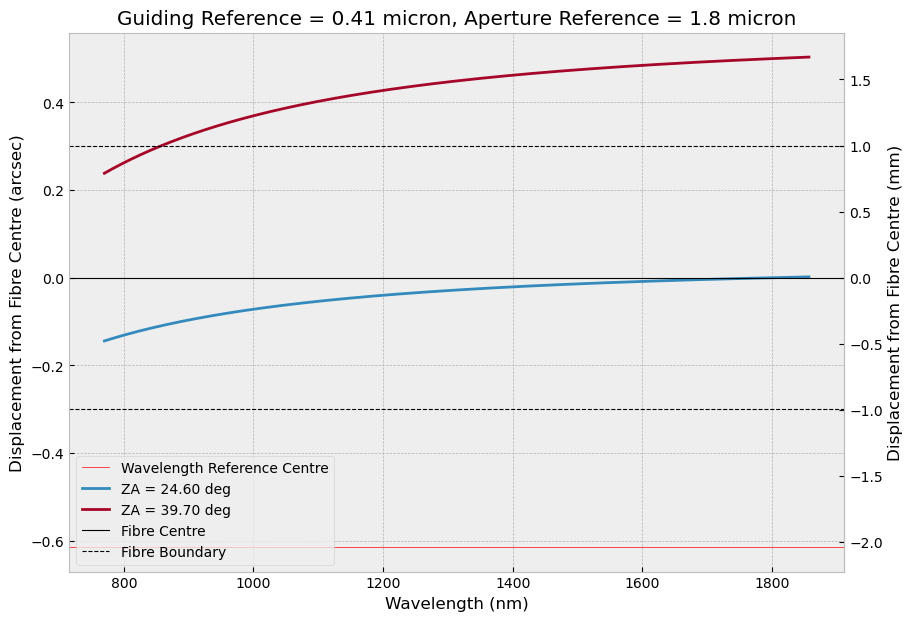

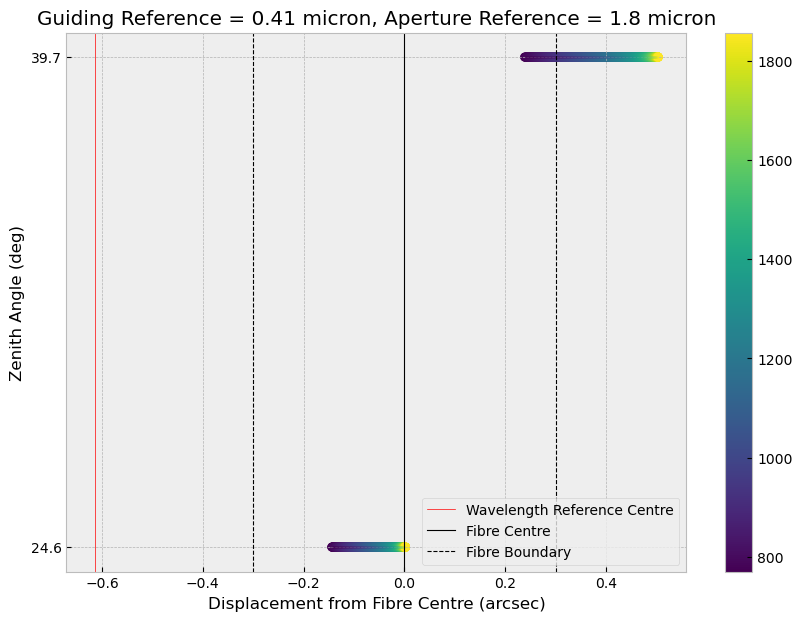

In [5]:
# analysis=AD_analysis()
# analysis.load_airmasses(ZA_range=[34.627, 37.59315339, 45.33753609, 55.89851346])
# analysis.load_wave("LR","VIS","B","B",sampling=1*u.nm)
# analysis.calculate_shifts(fibrecentre_waveref = 0.44 * u.micron,reposition=False)
# shift_plot(analysis.input_parameters,analysis.output_parameters,conditions)

analysis=AD_analysis()
analysis.load_airmasses(ZA_range=[24.6,39.7])
analysis.load_wave("LR","NIR","IY","H",sampling=1*u.nm)
analysis.calculate_shifts(fibrecentre_waveref = 1.8 * u.micron,reposition=False,guide_waveref=0.41*u.micron)
fibre_index=abs(int((analysis.output_parameters['wave_wavelengths'][0].value-1.8*1000)/1)) #sampling = 1
print(fibre_index)
print("Movement of NIR Fibre Centre from Start to End = {}".format(abs(analysis.output_parameters['shifts'][0][fibre_index]-analysis.output_parameters['shifts'][-1][fibre_index])))
shift_plot(analysis.input_parameters,analysis.output_parameters,conditions)

TRANSMISSION vs WAVELENGTH for VARIOUS AIRMASS


In [6]:
def trans_plot(input_parameters,output_parameters,conditions,normalise="none"):
    """
    Plots the wavelength vs transmission graph 
    Comes after load_wave, load_airmasses, calculate_snapshifts, calculate_snaptransmissions

    INPUTS:
    normalise: string, "none", "zenith", "centre", "both"
        what to normalise the transmission to; either no normalisation, relative to zenith, relative to transmission or fibre centre wavelength,
        or both the latter

    OUTPUTS:
    Graphs:
        corresponding graph
    """
    airmasses=output_parameters['airmasses']
    ZA_range=input_parameters['ZA_range']
    HA_range=input_parameters['HA_range']
    
    wave_wavelengths=output_parameters['wave_wavelengths']
    fibre_diameter=output_parameters['fibre_diameter']
    wave_transmissions=output_parameters['wave_transmissions']

    fibrecentre_waveref=input_parameters['fibrecentre_waveref']
    guide_waveref=input_parameters['guide_waveref']
    median_FWHM=input_parameters['median_FWHM']
    median_FWHM_lambda=input_parameters['median_FWHM_lambda']
    kolb_factor=input_parameters['kolb_factor']
    regime=input_parameters['regime']
    res=input_parameters['res']
    k_lim=input_parameters['k_lim']
    FWHM_change=input_parameters['FWHM_change']
    scale=input_parameters['scale']
    method=input_parameters['method']
    beta=input_parameters['beta']
    band=input_parameters['band']
    reposition=input_parameters['reposition']
    targ_dec=input_parameters['targ_dec']

    weights = np.arange(1, len(airmasses)+1)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)

    if ZA_range !=[]: #Zenith angle plots
        fig, ax = plt.subplots(figsize=(10,7))
        plt.axvline(fibrecentre_waveref.value*1000,color='black',linewidth=0.5,label='Fibre Centre Wavelength')

        if normalise == "zenith":
            print("Normalised to Zenith Transmission")
            if FWHM_change==True:
                zenith_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,1,median_FWHM,median_FWHM_lambda,kolb_factor)
            else:
                zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
            zenith_centre_shift=atm_diff.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
            zenith_shifts=atm_diff.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift
            if method == "analytical":
                zenith_transmission = trans_calc.analytical_gaussian(fibre_diameter,zenith_FWHMs,zenith_shifts,k_lim)
            if method == "numerical gaussian":
                zenith_transmission = []
                for i in range(0,len(zenith_FWHMs)):
                    zenith_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale))
            if method == "numerical moffat":
                zenith_transmission = []
                for i in range(0,len(zenith_FWHMs)):
                    zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(zenith_transmission),label='Zenith Angle = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1))    
            plt.ylabel("Transmission Relative to Zenith")

        if normalise == "centre":
            print("Normalised to Reference Wavelength Transmission")
            peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]          
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(wave_transmissions[i][peak]),label='Zenith Angle = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1))    
            plt.ylabel("Transmission Relative to Reference Wavelength")

        if normalise =="both":
            print("Normalised to Both Zenith Transmission and Reference Wavelength Transmission")
            if FWHM_change==True:
                zenith_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,1,median_FWHM,median_FWHM_lambda,kolb_factor)
            else:
                zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
            zenith_centre_shift=atm_diff.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
            zenith_shifts=atm_diff.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift
            if method == "analytical":
                zenith_transmission = trans_calc.analytical_gaussian(fibre_diameter,zenith_FWHMs,zenith_shifts,k_lim)
            if method == "numerical gaussian":
                zenith_transmission = []
                for i in range(0,len(zenith_FWHMs)):
                    zenith_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale))
            if method == "numerical moffat":
                zenith_transmission = []
                for i in range(0,len(zenith_FWHMs)):
                    zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
            peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(zenith_transmission)/(np.array(wave_transmissions)[i][peak]/np.array(zenith_transmission)[peak]),label='Zenith Angle = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1))
                plt.ylabel("Transmission (Normalised to Zenith and Ref. Wave. Transmission)")

        if normalise == "none":
            print("No Normalisation, Raw Transmission")
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='Zenith Angle = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1))
            plt.ylabel("Transmission")

        plt.xlabel("Wavelength [nm]")
        #plt.title('Fibre = %s, Guide = %s, %s %s, FWHM Change = %s, Repos = %s, Method = %s' %(fibrecentre_waveref,guide_waveref,regime,band,FWHM_change,reposition,method))

        plt.ylim(0,1.3)
        
        plt.legend()

    if HA_range != []: #HA plots
        fig, ax = plt.subplots(figsize=(10,7))
        plt.axvline(fibrecentre_waveref.value*1000,color='black',linewidth=0.5,label='Fibre Centre Wavelength')
        meridian_airmass=output_parameters['meridian_airmass']
        if normalise == "meridian":
            print("Normalised to Target's Meridian Transmission (LHA=0h)")
            if FWHM_change==True:
                merid_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,meridian_airmass,median_FWHM,median_FWHM_lambda,kolb_factor)
            else:
                merid_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
            merid_centre_shift=atm_diff.diff_shift(fibrecentre_waveref,meridian_airmass,guide_waveref,conditions)
            merid_shifts=atm_diff.diff_shift(wave_wavelengths,meridian_airmass,guide_waveref,conditions)-merid_centre_shift
            if method == "analytical":
                merid_transmission = trans_calc.analytical_gaussian(fibre_diameter,merid_FWHMs,merid_shifts,k_lim)
            if method == "numerical gaussian":
                merid_transmission = []
                for i in range(0,len(merid_FWHMs)):
                    merid_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale))
            if method == "numerical moffat":
                merid_transmission = []
                for i in range(0,len(merid_FWHMs)):
                    merid_transmission.append(trans_calc.numerical_moffat(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale,beta=beta))
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(merid_transmission),label='HA = %2.2fh' %(HA_range[i]),color=cmap.to_rgba(i+1))
            plt.ylabel("Transmission Relative to Target's at Meridian")

        if normalise == "centre":
            print("Normalised to Reference Wavelength Transmission")
            peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(wave_transmissions[i][peak]),label='HA = %2.2fh' %(HA_range[i]),color=cmap.to_rgba(i+1))
            plt.ylabel("Transmission Relative to Reference Wavelength")

        if normalise =="both":
            print("Normalised to Both Target's Meridian Transmission and Reference Wavelength Transmission")
            if FWHM_change==True:
                merid_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,meridian_airmass,median_FWHM,median_FWHM_lambda,kolb_factor)
            else:
                merid_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
            merid_centre_shift=atm_diff.diff_shift(fibrecentre_waveref,meridian_airmass,guide_waveref,conditions)
            merid_shifts=atm_diff.diff_shift(wave_wavelengths,meridian_airmass,guide_waveref,conditions)-merid_centre_shift
            if method == "analytical":
                merid_transmission = trans_calc.analytical_gaussian(fibre_diameter,merid_FWHMs,merid_shifts,k_lim)
            if method == "numerical gaussian":
                merid_transmission = []
                for i in range(0,len(merid_FWHMs)):
                    merid_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale))
            if method == "numerical moffat":
                merid_transmission = []
                for i in range(0,len(merid_FWHMs)):
                    merid_transmission.append(trans_calc.numerical_moffat(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale,beta=beta))
            peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(merid_transmission)/(np.array(wave_transmissions)[i][peak]/np.array(merid_transmission)[peak]),label='HA = %2.0fh' %(HA_range[i]),color=cmap.to_rgba(i+1))
                plt.ylabel("Transmission (Normalised to Target at Meridian and Ref. Wave. Transmission)")

        if normalise == "none":
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='HA = %2.2fh' %(HA_range[i]),color=cmap.to_rgba(i+1))
            plt.ylabel("Transmission")

        plt.xlabel("Wavelength [nm]")
        #plt.title('Fibre = %s, Guide = %s, %s %s, FWHM Change = %s, Dec = %2.2f, Repos = %s, Method = %s' %(fibrecentre_waveref,guide_waveref,regime,band,FWHM_change,targ_dec.value,reposition,method))
        plt.ylim(0,1.3)
        plt.legend()

HA used


/Users/Jay.Stephan/Library/CloudStorage/OneDrive-ScienceandTechnologyFacilitiesCouncil/Documents/Work/MOSAIC/AD/AD-Code/Version 2/AD_analysis.py:143: RuntimeWarning: invalid value encountered in arccos
  LHA_below_horizon=np.rad2deg(np.arccos(-np.tan(lat)*np.tan(dec)))/15 #Local Hour Angle the target goes below the Horizon


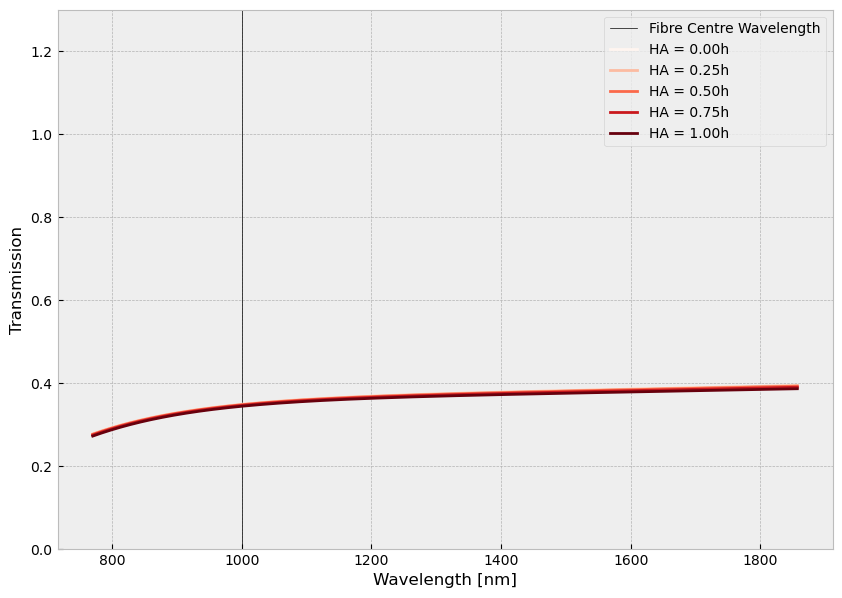

In [7]:
analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm)
#analysis.load_airmasses(ZA_range=[0,5,10,15,20,25,30,35,40,45,50,55,60])
analysis.load_airmasses(HA_range=[0,0.25,0.5,0.75,1],targ_dec=-70 * u.deg)
analysis.calculate_shifts(fibrecentre_waveref = 1 * u.micron,reposition=True, guide_waveref=0.6 * u.micron)
analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01)
trans_plot(analysis.input_parameters,analysis.output_parameters,conditions,normalise="none")

Zenith Angles Used
Normalised to Reference Wavelength Transmission
Zenith Angles Used
Normalised to Reference Wavelength Transmission


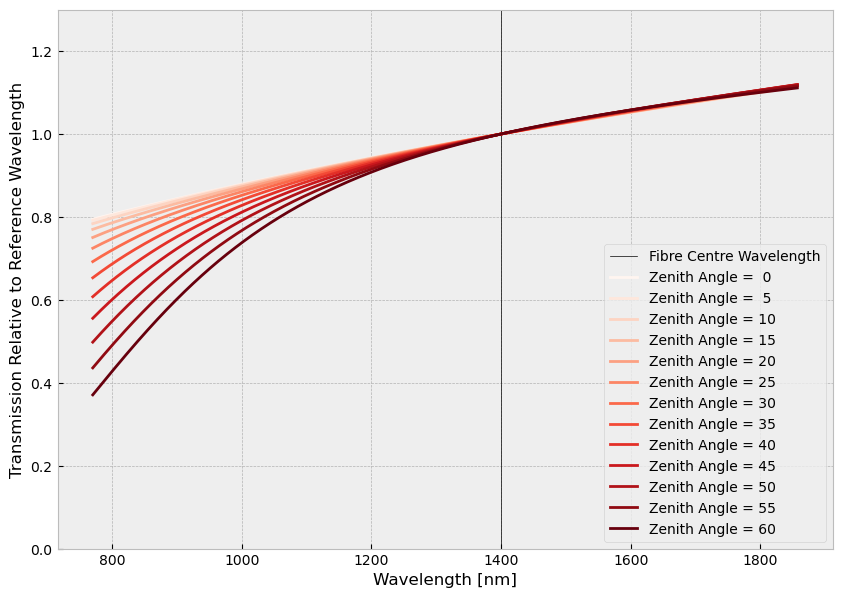

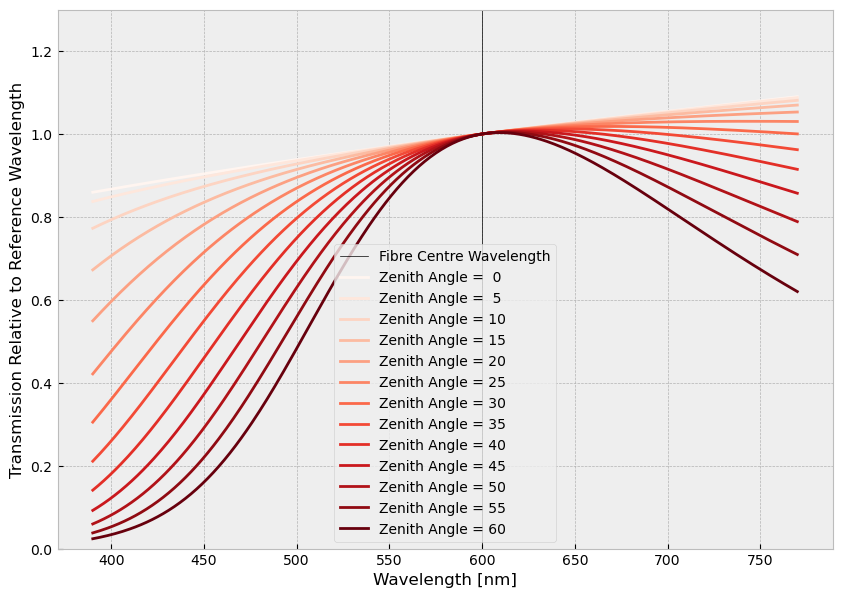

In [8]:
analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm)
#analysis.load_airmasses(HA_range=[0,1,2,3,4],targ_dec=40 * u.deg)
analysis.load_airmasses(ZA_range=[0,5,10,15,20,25,30,35,40,45,50,55,60])
analysis.calculate_shifts(fibrecentre_waveref = 1.4 * u.micron,reposition=True, guide_waveref=1.4 * u.micron)
analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01, beta=2.5)
trans_plot(analysis.input_parameters,analysis.output_parameters,conditions,normalise="centre")

analysis=AD_analysis()
analysis.load_wave('LR','VIS','B','R',sampling=1 * u.nm)
#analysis.load_airmasses(HA_range=[0,1,2,3,4],targ_dec=40 * u.deg)
analysis.load_airmasses(ZA_range=[0,5,10,15,20,25,30,35,40,45,50,55,60])
analysis.calculate_shifts(fibrecentre_waveref = .6 * u.micron,reposition=True, guide_waveref=0.6 * u.micron)
analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01, beta=2.5)
trans_plot(analysis.input_parameters,analysis.output_parameters,conditions,normalise="centre")

Separation OF RED AND BLUE vs ZENITH ANGLE for VARIOUS BANDS

In [9]:
def red_blue_separation(config):
    separations=[]
    for i in config:
        Config_regime = ConfigObj('./Architecture_parameters/'+i[0]+'_channel_conf.ini')
        sampling = -int(Config_regime[i[1]]['Bands'][i[2]]['wave_min'])+int(Config_regime[i[1]]['Bands'][i[3]]['wave_max'])
        analysis.load_wave(i[1],i[0],i[2],i[3],sampling * u.nm)
        analysis.calculate_shifts(fibrecentre_waveref = 100 * u.micron, reposition=False, guide_waveref=200 * u.micron)
        separation=[]
        for o in analysis.output_parameters['shifts']:
            separation.append(abs(o[0]-o[1]).value)
        separations.append(separation)
    return separations


In [10]:
angles=ZA_range=np.arange(0,60)
analysis=AD_analysis()
analysis.load_airmasses(ZA_range=angles)


NIR_LR=[["NIR","LR","IY","H"],["NIR","LR","J","J"],["NIR","LR","IY","IY"],["NIR","LR","H","H"]]
NIR_HR=[["NIR","HR","IY","H"],["NIR","HR","IY","IY"],["NIR","HR","H","H"]]
VIS_LR=[["VIS","LR","B","R"],["VIS","LR","B","B"],["VIS","LR","V","V"],["VIS","LR","R","R"]]
VIS_HR=[["VIS","HR","V","R"],["VIS","HR","V","V"],["VIS","HR","R","R"]]

NIR_LR_sep=red_blue_separation(NIR_LR)
NIR_HR_sep=red_blue_separation(NIR_HR)
VIS_LR_sep=red_blue_separation(VIS_LR)
VIS_HR_sep=red_blue_separation(VIS_HR)

Zenith Angles Used


In [11]:
weights4 = np.arange(0, 4+1)
norm4 = mpl.colors.Normalize(vmin=min(weights4), vmax=max(weights4))
cmap4_1 = mpl.cm.ScalarMappable(norm=norm4, cmap=mpl.cm.Reds)
cmap4_2 = mpl.cm.ScalarMappable(norm=norm4, cmap=mpl.cm.Blues)

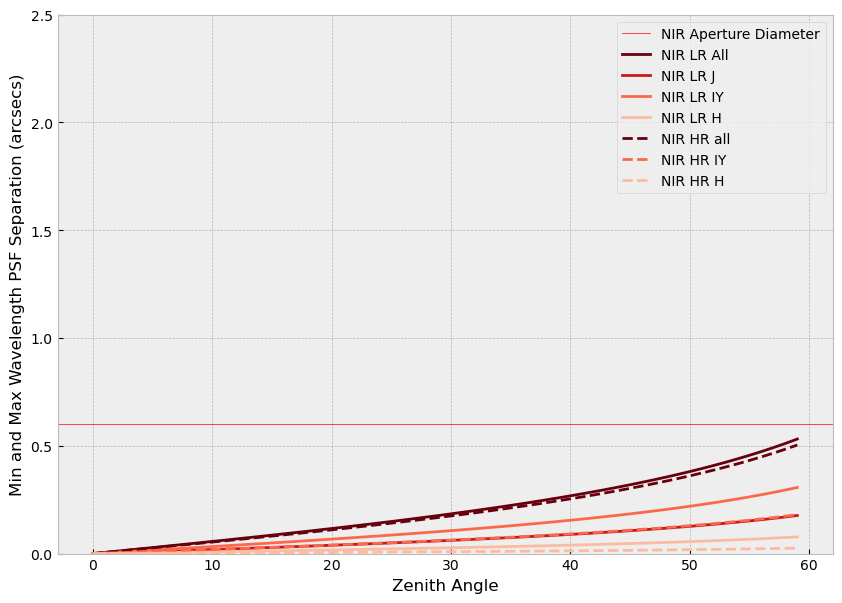

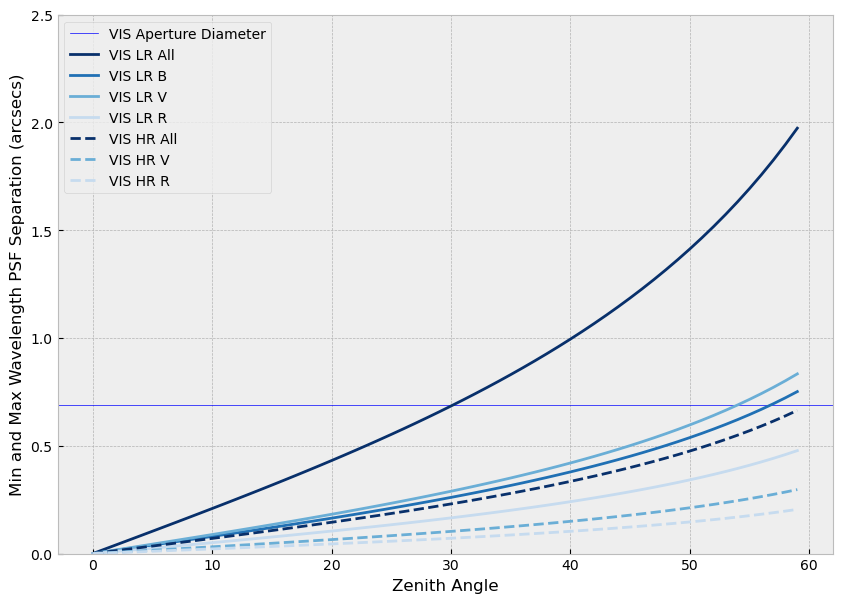

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
plt.axhline(0.6,color='red',linewidth=0.5,label='NIR Aperture Diameter')
plt.plot(angles,NIR_LR_sep[0],label="NIR LR All",color=cmap4_1.to_rgba(3+1))
plt.plot(angles,NIR_LR_sep[1],label="NIR LR J",color=cmap4_1.to_rgba(2+1))
plt.plot(angles,NIR_LR_sep[2],label="NIR LR IY",color=cmap4_1.to_rgba(1+1))
plt.plot(angles,NIR_LR_sep[3],label="NIR LR H",color=cmap4_1.to_rgba(0+1))
plt.plot(angles,NIR_HR_sep[0],label="NIR HR all",color=cmap4_1.to_rgba(3+1),linestyle='--')
plt.plot(angles,NIR_HR_sep[1],label="NIR HR IY",color=cmap4_1.to_rgba(1+1),linestyle='--')
plt.plot(angles,NIR_HR_sep[2],label="NIR HR H",color=cmap4_1.to_rgba(0+1),linestyle='--')
plt.ylabel("Min and Max Wavelength PSF Separation (arcsecs)")
plt.xlabel("Zenith Angle")
plt.legend()
plt.ylim(0,2.5)
plt.savefig("IR_sep.png",dpi=600)
fig, ax = plt.subplots(figsize=(10,7))
plt.axhline(0.69,color='blue',linewidth=0.5,label='VIS Aperture Diameter')
plt.plot(angles,VIS_LR_sep[0],label="VIS LR All",color=cmap4_2.to_rgba(3+1))
plt.plot(angles,VIS_LR_sep[1],label="VIS LR B",color=cmap4_2.to_rgba(2+1))
plt.plot(angles,VIS_LR_sep[2],label="VIS LR V",color=cmap4_2.to_rgba(1+1))
plt.plot(angles,VIS_LR_sep[3],label="VIS LR R",color=cmap4_2.to_rgba(0+1))
plt.plot(angles,VIS_HR_sep[0],label="VIS HR All",color=cmap4_2.to_rgba(3+1),linestyle='--')
plt.plot(angles,VIS_HR_sep[1],label="VIS HR V",color=cmap4_2.to_rgba(1+1),linestyle='--')
plt.plot(angles,VIS_HR_sep[2],label="VIS HR R",color=cmap4_2.to_rgba(0+1),linestyle='--')
plt.ylabel("Min and Max Wavelength PSF Separation (arcsecs)")
plt.xlabel("Zenith Angle")
plt.legend()
plt.ylim(0,2.5)
plt.savefig("VIS_sep.png",dpi=600)

TRANSMISSION vs WAVELENGTH for VARIOUS AIRMASS and VARIOUS TRANSMISSION METHODS


In [13]:
#allow beta to be an argument
def multi_trans_plot(input_parameters,output_parameters,conditions,methods=[1,2],normalise='none',scale=0.01,beta=2.5):
    airmasses=output_parameters['airmasses']
    ZA_range=input_parameters['ZA_range']
    HA_range=input_parameters['HA_range']
    fibrecentre_waveref=input_parameters['fibrecentre_waveref']
    method_options=["analytical","numerical gaussian","numerical moffat"]
    method_labels=["ana. gaussian","num. gaussian","num. moffat"]
    style=["--","-","-."]
    fig, ax = plt.subplots(figsize=(10,7))
    plt.axvline(fibrecentre_waveref.value*1000,color='black',linewidth=0.5,label='Fibre Centre Wavelength')

    for o in methods:
        analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method=method_options[o],scale=scale,beta=beta)
        
        wave_wavelengths=output_parameters['wave_wavelengths']
        fibre_diameter=output_parameters['fibre_diameter']
        wave_transmissions=output_parameters['wave_transmissions']
        guide_waveref=input_parameters['guide_waveref']
        median_FWHM=input_parameters['median_FWHM']
        median_FWHM_lambda=input_parameters['median_FWHM_lambda']
        kolb_factor=input_parameters['kolb_factor']
        regime=input_parameters['regime']
        res=input_parameters['res']
        k_lim=input_parameters['k_lim']
        FWHM_change=input_parameters['FWHM_change']
        scale=input_parameters['scale']
        method=input_parameters['method']
        beta=input_parameters['beta']
        print(beta)
        band=input_parameters['band']
        reposition=input_parameters['reposition']
        targ_dec=input_parameters['targ_dec']

        weights = np.arange(1, len(airmasses)+1)
        norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)

        if ZA_range !=[]: #Zenith angle plots
            if normalise == "zenith":
                print("Normalised to Zenith Transmission")
                if FWHM_change==True:
                    zenith_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,1,median_FWHM,median_FWHM_lambda,kolb_factor)
                else:
                    zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
                zenith_centre_shift=atm_shift.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
                zenith_shifts=atm_shift.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift
                if method == "analytical":
                    zenith_transmission = trans_calc.analytical_gaussian(fibre_diameter,zenith_FWHMs,zenith_shifts,k_lim)
                if method == "numerical gaussian":
                    zenith_transmission = []
                    for i in range(0,len(zenith_FWHMs)):
                        zenith_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale))
                if method == "numerical moffat":
                    zenith_transmission = []
                    for i in range(0,len(zenith_FWHMs)):
                        zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(zenith_transmission),label='ZA = %2.0f, %s' %(ZA_range[i],method_labels[o]),color=cmap.to_rgba(i+1),linestyle=style[o])    
                plt.ylabel("Transmission Relative to Zenith")

            if normalise == "centre":
                print("Normalised to Reference Wavelength Transmission")
                peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]          
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(wave_transmissions[i][peak]),label='ZA = %2.0f, %s' %(ZA_range[i],method_labels[o]),color=cmap.to_rgba(i+1),linestyle=style[o])    
                plt.ylabel("Transmission Relative to Reference Wavelength")

            if normalise =="both":
                print("Normalised to Both Zenith Transmission and Reference Wavelength Transmission")
                if FWHM_change==True:
                    zenith_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,1,median_FWHM,median_FWHM_lambda,kolb_factor)
                else:
                    zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
                zenith_centre_shift=atm_shift.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
                zenith_shifts=atm_shift.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift
                if method == "analytical":
                    zenith_transmission = trans_calc.analytical_gaussian(fibre_diameter,zenith_FWHMs,zenith_shifts,k_lim)
                if method == "numerical gaussian":
                    zenith_transmission = []
                    for i in range(0,len(zenith_FWHMs)):
                        zenith_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale))
                if method == "numerical moffat":
                    zenith_transmission = []
                    for i in range(0,len(zenith_FWHMs)):
                        zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
                peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(zenith_transmission)/(np.array(wave_transmissions)[i][peak]/np.array(zenith_transmission)[peak]),label='ZA = %2.0f, %s' %(ZA_range[i],method_labels[o]),color=cmap.to_rgba(i+1),linestyle=style[o])
                    plt.ylabel("Transmission (Normalised to Zenith and Ref. Wave. Transmission)")

            if normalise == "none":
                print("No Normalisation, Raw Transmission")
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='ZA = %2.0f, %s' %(ZA_range[i],method_labels[o]),color=cmap.to_rgba(i+1),linestyle=style[o])
                plt.ylabel("Transmission")

            plt.xlabel("Wavelength [nm]")
            plt.title('Fibre = %s, Guide = %s, %s %s, FWHM Change = %s, Repos = %s' %(fibrecentre_waveref,guide_waveref,regime,band,FWHM_change,reposition))
            plt.ylim(0,1.3)
            plt.legend()

        if HA_range != []: #HA plots
            meridian_airmass=output_parameters['meridian_airmass']
            if normalise == "meridian":
                print("Normalised to Target's Meridian Transmission (LHA=0h)")
                if FWHM_change==True:
                    merid_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,meridian_airmass,median_FWHM,median_FWHM_lambda,kolb_factor)
                else:
                    merid_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
                merid_centre_shift=atm_shift.diff_shift(fibrecentre_waveref,meridian_airmass,guide_waveref,conditions)
                merid_shifts=atm_shift.diff_shift(wave_wavelengths,meridian_airmass,guide_waveref,conditions)-merid_centre_shift
                if method == "analytical":
                    merid_transmission = trans_calc.analytical_gaussian(fibre_diameter,merid_FWHMs,merid_shifts,k_lim)
                if method == "numerical gaussian":
                    merid_transmission = []
                    for i in range(0,len(merid_FWHMs)):
                        merid_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale))
                if method == "numerical moffat":
                    merid_transmission = []
                    for i in range(0,len(merid_FWHMs)):
                        merid_transmission.append(trans_calc.numerical_moffat(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale,beta=beta))
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(merid_transmission),label='HA = %2.2fh, %s' %(HA_range[i], method_labels[o]),color=cmap.to_rgba(i+1),linestyle=style[o])
                plt.ylabel("Transmission Relative to Target's at Meridian")

            if normalise == "centre":
                print("Normalised to Reference Wavelength Transmission")
                peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(wave_transmissions[i][peak]),label='HA = %2.2fh, %s' %(HA_range[i],method_labels[o]),color=cmap.to_rgba(i+1),linestyle=style[o])
                plt.ylabel("Transmission Relative to Reference Wavelength")

            if normalise =="both":
                print("Normalised to Both Target's Meridian Transmission and Reference Wavelength Transmission")
                if FWHM_change==True:
                    merid_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,meridian_airmass,median_FWHM,median_FWHM_lambda,kolb_factor)
                else:
                    merid_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
                merid_centre_shift=atm_shift.diff_shift(fibrecentre_waveref,meridian_airmass,guide_waveref,conditions)
                merid_shifts=atm_shift.diff_shift(wave_wavelengths,meridian_airmass,guide_waveref,conditions)-merid_centre_shift
                if method == "analytical":
                    merid_transmission = trans_calc.analytical_gaussian(fibre_diameter,merid_FWHMs,merid_shifts,k_lim)
                if method == "numerical gaussian":
                    merid_transmission = []
                    for i in range(0,len(merid_FWHMs)):
                        merid_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale))
                if method == "numerical moffat":
                    merid_transmission = []
                    for i in range(0,len(merid_FWHMs)):
                        merid_transmission.append(trans_calc.numerical_moffat(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale,beta=beta))
                peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(merid_transmission)/(np.array(wave_transmissions)[i][peak]/np.array(merid_transmission)[peak]),label='HA = %2.0fh, %s' %(HA_range[i],method_labels[o]),color=cmap.to_rgba(i+1),linestyle=style[o])
                    plt.ylabel("Transmission (Normalised to Target at Meridian and Ref. Wave. Transmission)")

            if normalise == "none":
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='HA = %2.2fh' %(HA_range[i]),color=cmap.to_rgba(i+1),linestyle=style[o])
                plt.ylabel("Transmission")

            plt.xlabel("Wavelength [nm]")
            plt.title('Fibre = %s, Guide = %s, %s %s, FWHM Change = %s, Dec = %2.2f, Repos = %s' %(fibrecentre_waveref,guide_waveref,regime,band,FWHM_change,targ_dec.value,reposition))
            plt.ylim(0,1.3)
            plt.legend()

Zenith Angles Used
2.5
No Normalisation, Raw Transmission
2.5
No Normalisation, Raw Transmission


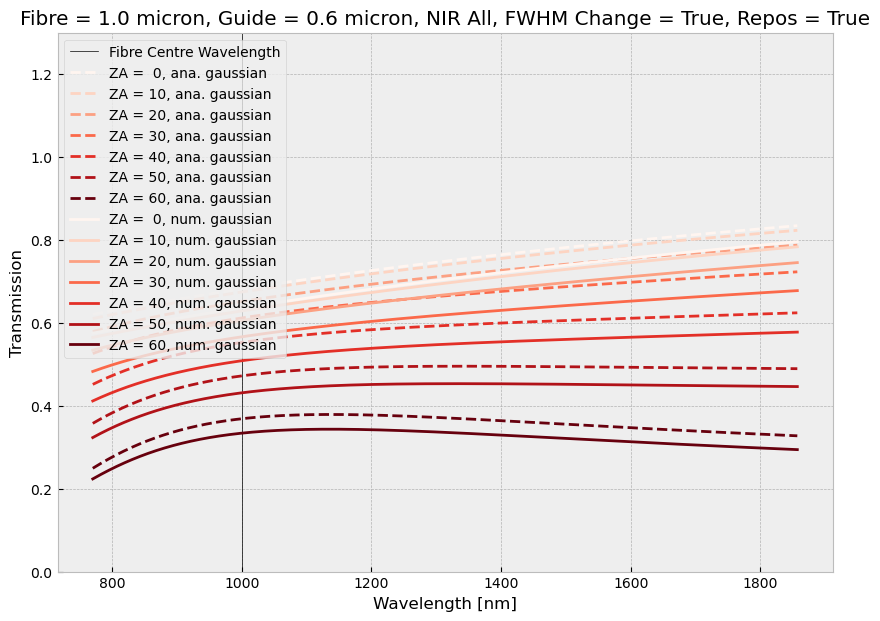

In [14]:
analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm)
analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])
analysis.calculate_shifts(fibrecentre_waveref = 1 * u.micron,reposition=True, guide_waveref=0.6 * u.micron)
multi_trans_plot(analysis.input_parameters,analysis.output_parameters,analysis.conditions,methods=[0,1],scale=0.1)

Zenith Angles Used
2.5
No Normalisation, Raw Transmission
2.5
No Normalisation, Raw Transmission


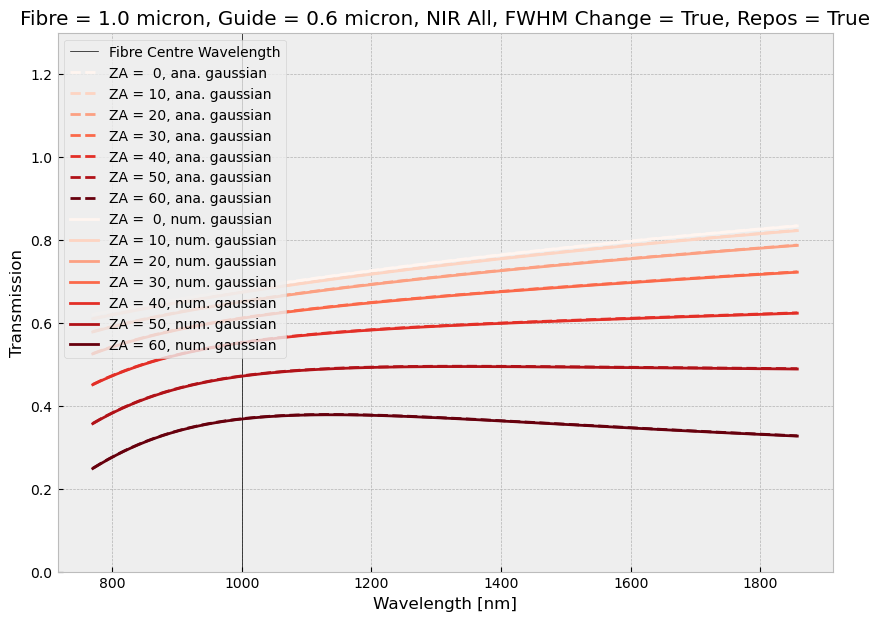

In [15]:
analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm)
analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])
analysis.calculate_shifts(fibrecentre_waveref = 1 * u.micron,reposition=True, guide_waveref=0.6 * u.micron)
multi_trans_plot(analysis.input_parameters,analysis.output_parameters,analysis.conditions,methods=[0,1],scale=0.01)

Zenith Angles Used
2.5
No Normalisation, Raw Transmission
2.5
No Normalisation, Raw Transmission


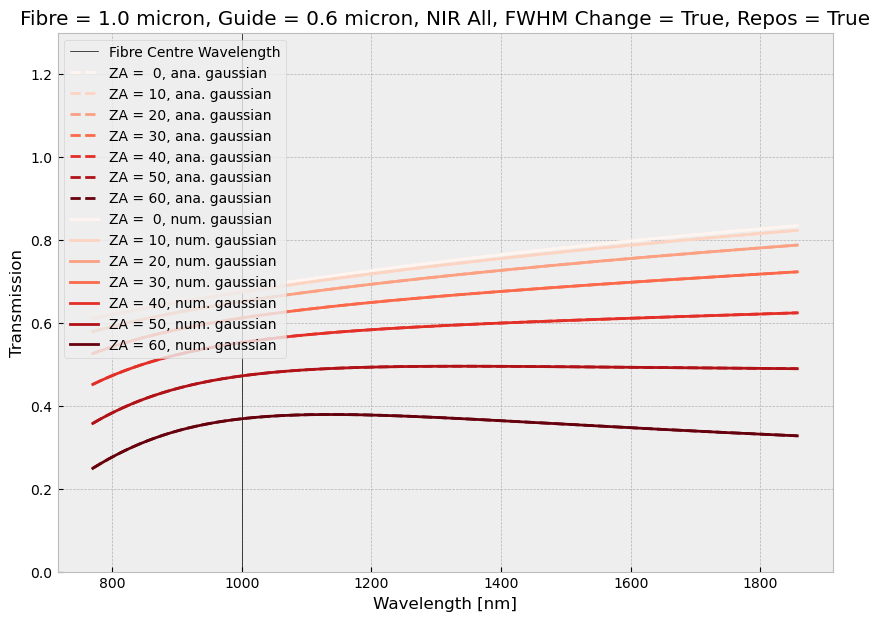

In [16]:
analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm)
analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])
analysis.calculate_shifts(fibrecentre_waveref = 1 * u.micron,reposition=True, guide_waveref=0.6 * u.micron)
multi_trans_plot(analysis.input_parameters,analysis.output_parameters,analysis.conditions,methods=[0,1],scale=0.001)

TRANSMISSION vs WAVELENGTH for VARIOUS AIRMASSES with REPOSITION INTERVALS

In [17]:
def calculate_integtransmissions(self, start_HA, end_HA, repos_interval, intervals, method="analytical"):

    HA_ranges=[]
    for i in range(0,int((end_HA-start_HA)/repos_interval)):
        HA_ranges.append(np.linspace(i*repos_interval+start_HA,(i+1)*repos_interval+start_HA,intervals))
    
    transmissions=[]

    for i in range(0,int((end_HA-start_HA)/repos_interval)):
        self.load_airmasses(HA_range=HA_ranges[i],targ_dec=0 * u.deg)
        self.calculate_snapshifts(fibrecentre_waveref = 1 * u.micron,plot=False, reposition=False, guide_waveref=0.6 * u.micron)
        self.calculate_snaptransmissions(FWHM_change=True,method=method)
        transmissions.append(self.output_parameters['wave_transmissions'])

    weights = np.arange(0, int(intervals*(end_HA-start_HA)/repos_interval)+1)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
    style=['-','--','-.']

    fig, ax = plt.subplots(figsize=(10,7))
    for i in range(0,len(transmissions)):
        for o in range(0,len(transmissions[i])):
            factor=0
            if o == 0: 
                factor = -1
        
            plt.plot(self.output_parameters['wave_wavelengths'],transmissions[i][o],linestyle=style[o],color=cmap.to_rgba(o+i*len(transmissions[0])+factor),label="Repos = %2.2fh, HA = %2.2fh" %(i,HA_ranges[i][o]))
    plt.legend()
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Transmission")
    plt.ylim(0,1.1)

TRANSMISSION vs WAVELENGTH for VARIOUS AIRMASS and VARIOUS MOFFAT BETAS


In [18]:
#allow beta to be an argument
def multi_moffat_plot(input_parameters,output_parameters,conditions,betas=[2.5,3.5,4.765],normalise='none',scale=0.01):
    airmasses=output_parameters['airmasses']
    ZA_range=input_parameters['ZA_range']
    HA_range=input_parameters['HA_range']
    fibrecentre_waveref=input_parameters['fibrecentre_waveref']
    style=["-","--","-."]
    fig, ax = plt.subplots(figsize=(10,7))
    plt.axvline(fibrecentre_waveref.value*1000,color='black',linewidth=0.5,label='Fibre Centre Wavelength')

    for count, o in enumerate(betas,start=0):
        analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=scale,beta=o)
        
        wave_wavelengths=output_parameters['wave_wavelengths']
        fibre_diameter=output_parameters['fibre_diameter']
        wave_transmissions=output_parameters['wave_transmissions']
        guide_waveref=input_parameters['guide_waveref']
        median_FWHM=input_parameters['median_FWHM']
        median_FWHM_lambda=input_parameters['median_FWHM_lambda']
        kolb_factor=input_parameters['kolb_factor']
        regime=input_parameters['regime']
        res=input_parameters['res']
        k_lim=input_parameters['k_lim']
        FWHM_change=input_parameters['FWHM_change']
        scale=input_parameters['scale']
        method=input_parameters['method']
        beta=input_parameters['beta']
        print(beta)
        band=input_parameters['band']
        reposition=input_parameters['reposition']
        targ_dec=input_parameters['targ_dec']

        weights = np.arange(1, len(airmasses)+1)
        norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)

        if ZA_range !=[]: #Zenith angle plots
            if normalise == "zenith":
                print("Normalised to Zenith Transmission")
                if FWHM_change==True:
                    zenith_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,1,median_FWHM,median_FWHM_lambda,kolb_factor)
                else:
                    zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
                zenith_centre_shift=atm_shift.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
                zenith_shifts=atm_shift.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift
                zenith_transmission = []
                for i in range(0,len(zenith_FWHMs)):
                    zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(zenith_transmission),label='ZA = %2.0f, B = %2.2f' %(ZA_range[i],o),color=cmap.to_rgba(i+1),linestyle=style[count])    
                plt.ylabel("Transmission Relative to Zenith")

            if normalise == "centre":
                print("Normalised to Reference Wavelength Transmission")
                peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]          
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(wave_transmissions[i][peak]),label='ZA = %2.0f, B = %2.2f' %(ZA_range[i],o),color=cmap.to_rgba(i+1),linestyle=style[count])    
                plt.ylabel("Transmission Relative to Reference Wavelength")

            if normalise =="both":
                print("Normalised to Both Zenith Transmission and Reference Wavelength Transmission")
                if FWHM_change==True:
                    zenith_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,1,median_FWHM,median_FWHM_lambda,kolb_factor)
                else:
                    zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
                zenith_centre_shift=atm_shift.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
                zenith_shifts=atm_shift.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift
                zenith_transmission = []
                for i in range(0,len(zenith_FWHMs)):
                    zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
                peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(zenith_transmission)/(np.array(wave_transmissions)[i][peak]/np.array(zenith_transmission)[peak]),label='ZA = %2.0f, B = %2.2f' %(ZA_range[i],o),color=cmap.to_rgba(i+1),linestyle=style[count])
                    plt.ylabel("Transmission (Normalised to Zenith and Ref. Wave. Transmission)")

            if normalise == "none":
                print("No Normalisation, Raw Transmission")
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='ZA = %2.0f, B = %2.2f' %(ZA_range[i],o),color=cmap.to_rgba(i+1),linestyle=style[count])
                plt.ylabel("Transmission")

            plt.xlabel("Wavelength [nm]")
            plt.title('Fibre = %s, Guide = %s, %s %s, FWHM Change = %s, Repos = %s' %(fibrecentre_waveref,guide_waveref,regime,band,FWHM_change,reposition))
            plt.ylim(0,1.3)
            plt.legend()

        if HA_range != []: #HA plots
            meridian_airmass=output_parameters['meridian_airmass']
            if normalise == "meridian":
                print("Normalised to Target's Meridian Transmission (LHA=0h)")
                if FWHM_change==True:
                    merid_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,meridian_airmass,median_FWHM,median_FWHM_lambda,kolb_factor)
                else:
                    merid_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
                merid_centre_shift=atm_shift.diff_shift(fibrecentre_waveref,meridian_airmass,guide_waveref,conditions)
                merid_shifts=atm_shift.diff_shift(wave_wavelengths,meridian_airmass,guide_waveref,conditions)-merid_centre_shift
                merid_transmission = []
                for i in range(0,len(merid_FWHMs)):
                    merid_transmission.append(trans_calc.numerical_moffat(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale,beta=beta))
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(merid_transmission),label='HA = %2.2fh, B = %2.2f' %(HA_range[i], o),color=cmap.to_rgba(i+1),linestyle=style[count])
                plt.ylabel("Transmission Relative to Target's at Meridian")

            if normalise == "centre":
                print("Normalised to Reference Wavelength Transmission")
                peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(wave_transmissions[i][peak]),label='HA = %2.2fh, B = %2.2f' %(HA_range[i], o),color=cmap.to_rgba(i+1),linestyle=style[count])
                plt.ylabel("Transmission Relative to Reference Wavelength")

            if normalise =="both":
                print("Normalised to Both Target's Meridian Transmission and Reference Wavelength Transmission")
                if FWHM_change==True:
                    merid_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,meridian_airmass,median_FWHM,median_FWHM_lambda,kolb_factor)
                else:
                    merid_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
                merid_centre_shift=atm_shift.diff_shift(fibrecentre_waveref,meridian_airmass,guide_waveref,conditions)
                merid_shifts=atm_shift.diff_shift(wave_wavelengths,meridian_airmass,guide_waveref,conditions)-merid_centre_shift
                if method == "analytical":
                    merid_transmission = trans_calc.analytical_gaussian(fibre_diameter,merid_FWHMs,merid_shifts,k_lim)
                if method == "numerical gaussian":
                    merid_transmission = []
                    for i in range(0,len(merid_FWHMs)):
                        merid_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale))
                if method == "numerical moffat":
                    merid_transmission = []
                    for i in range(0,len(merid_FWHMs)):
                        merid_transmission.append(trans_calc.numerical_moffat(fibre_diameter,merid_FWHMs[i],merid_shifts[i],scale,beta=beta))
                peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(merid_transmission)/(np.array(wave_transmissions)[i][peak]/np.array(merid_transmission)[peak]),label='HA = %2.2fh, B = %2.2f' %(HA_range[i], o),color=cmap.to_rgba(i+1),linestyle=style[count])
                    plt.ylabel("Transmission (Normalised to Target at Meridian and Ref. Wave. Transmission)")

            if normalise == "none":
                for i in range(0,len(wave_transmissions)):
                    plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='HA = %2.2fh' %(HA_range[i]),color=cmap.to_rgba(i+1),linestyle=style[count])
                plt.ylabel("Transmission")

            plt.xlabel("Wavelength [nm]")
            plt.title('Fibre = %s, Guide = %s, %s %s, FWHM Change = %s, Dec = %2.2f, Repos = %s' %(fibrecentre_waveref,guide_waveref,regime,band,FWHM_change,targ_dec.value,reposition))
            plt.ylim(0,1.3)
            plt.legend()

Zenith Angles Used
2.5
No Normalisation, Raw Transmission
3.5
No Normalisation, Raw Transmission
4.765
No Normalisation, Raw Transmission


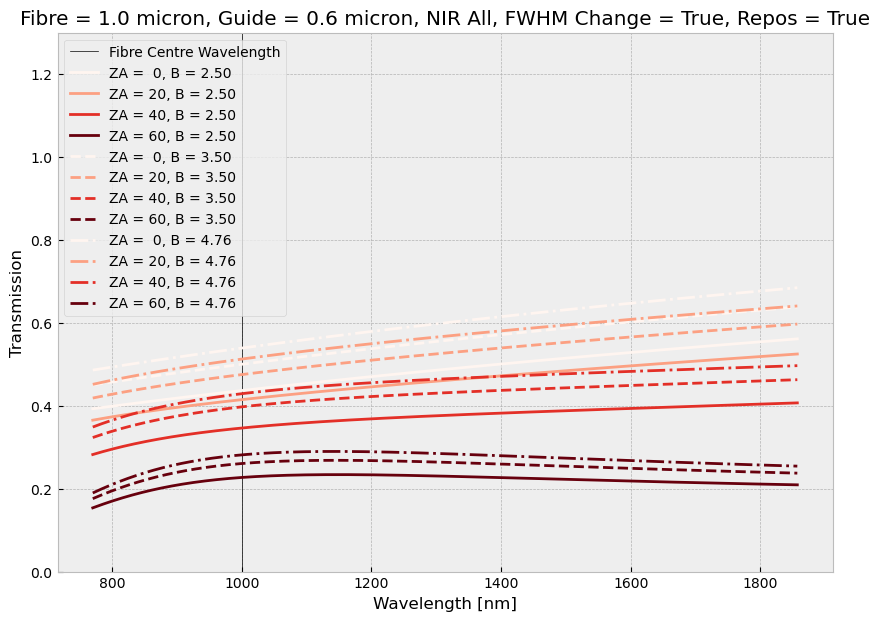

In [19]:
analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm)
analysis.load_airmasses(ZA_range=[0,20,40,60])
analysis.calculate_shifts(fibrecentre_waveref = 1 * u.micron,reposition=True, guide_waveref=0.6 * u.micron)
multi_moffat_plot(analysis.input_parameters,analysis.output_parameters,analysis.conditions,scale=0.1)

In [36]:
def trans_plot2(input_parameters,output_parameters,conditions,normalise="none"):
    """
    Plots the wavelength vs transmission graph 
    Comes after load_wave, load_airmasses, calculate_snapshifts, calculate_snaptransmissions

    INPUTS:
    normalise: string, "none", "zenith", "centre", "both"
        what to normalise the transmission to; either no normalisation, relative to zenith, relative to transmission or fibre centre wavelength,
        or both the latter

    OUTPUTS:
    Graphs:
        corresponding graph
    """
    airmasses=output_parameters['airmasses']
    ZA_range=input_parameters['ZA_range']
    HA_range=input_parameters['HA_range']
    
    wave_wavelengths=output_parameters['wave_wavelengths']
    fibre_diameter=output_parameters['fibre_diameter']
    wave_transmissions=output_parameters['wave_transmissions']

    fibrecentre_waveref=input_parameters['fibrecentre_waveref']
    guide_waveref=input_parameters['guide_waveref']
    median_FWHM=input_parameters['median_FWHM']
    median_FWHM_lambda=input_parameters['median_FWHM_lambda']
    kolb_factor=input_parameters['kolb_factor']
    regime=input_parameters['regime']
    res=input_parameters['res']
    k_lim=input_parameters['k_lim']
    FWHM_change=input_parameters['FWHM_change']
    scale=input_parameters['scale']
    method=input_parameters['method']
    beta=input_parameters['beta']
    band=input_parameters['band']
    reposition=input_parameters['reposition']
    targ_dec=input_parameters['targ_dec']

    weights = np.arange(1, len(airmasses)+1)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    if regime=="NIR":
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
    elif regime=="VIS":
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)

    if ZA_range !=[]: #Zenith angle plots
        fig, ax = plt.subplots(figsize=(7,5))
        plt.axvline(fibrecentre_waveref.value*1000,color='black',linewidth=0.5,label='Aperture Centre Wavelength')

        if normalise == "zenith":
            print("Normalised to Zenith Transmission")
            if FWHM_change==True:
                zenith_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,1,median_FWHM,median_FWHM_lambda,kolb_factor)
            else:
                zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
            zenith_centre_shift=atm_diff.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
            zenith_shifts=atm_diff.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift
            if method == "analytical":
                zenith_transmission = trans_calc.analytical_gaussian(fibre_diameter,zenith_FWHMs,zenith_shifts,k_lim)
            if method == "numerical gaussian":
                zenith_transmission = []
                for i in range(0,len(zenith_FWHMs)):
                    zenith_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale))
            if method == "numerical moffat":
                zenith_transmission = []
                for i in range(0,len(zenith_FWHMs)):
                    zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(zenith_transmission),label='Zenith Angle = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1))    
            plt.ylabel("Transmission Relative to Zenith")

        if normalise == "centre":
            print("Normalised to Reference Wavelength Transmission")
            peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]          
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(wave_transmissions[i][peak]),label='Zenith Angle = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1))    
            plt.ylabel("Transmission Relative to Aperture Centre Wavelength")

        if normalise =="both":
            print("Normalised to Both Zenith Transmission and Reference Wavelength Transmission")
            if FWHM_change==True:
                zenith_FWHMs=trans_calc.calculate_FWHM(wave_wavelengths,1,median_FWHM,median_FWHM_lambda,kolb_factor)
            else:
                zenith_FWHMs=np.full(len(wave_wavelengths),median_FWHM) * u.arcsec
            zenith_centre_shift=atm_diff.diff_shift(fibrecentre_waveref,1,guide_waveref,conditions)
            zenith_shifts=atm_diff.diff_shift(wave_wavelengths,1,guide_waveref,conditions)-zenith_centre_shift
            if method == "analytical":
                zenith_transmission = trans_calc.analytical_gaussian(fibre_diameter,zenith_FWHMs,zenith_shifts,k_lim)
            if method == "numerical gaussian":
                zenith_transmission = []
                for i in range(0,len(zenith_FWHMs)):
                    zenith_transmission.append(trans_calc.numerical_gaussian(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale))
            if method == "numerical moffat":
                zenith_transmission = []
                for i in range(0,len(zenith_FWHMs)):
                    zenith_transmission.append(trans_calc.numerical_moffat(fibre_diameter,zenith_FWHMs[i],zenith_shifts[i],scale,beta=beta))
            peak = np.where(wave_wavelengths.value==fibrecentre_waveref.value*1000)[0][0]
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i])/np.array(zenith_transmission)/(np.array(wave_transmissions)[i][peak]/np.array(zenith_transmission)[peak]),label='Zenith Angle = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1))
                plt.ylabel("Transmission (Normalised to Zenith and Ref. Wave. Transmission)")

        if normalise == "none":
            print("No Normalisation, Raw Transmission")
            for i in range(0,len(wave_transmissions)):
                plt.plot(wave_wavelengths,np.array(wave_transmissions[i]),label='Zenith Angle = %2.0f' %(ZA_range[i]),color=cmap.to_rgba(i+1))
            plt.ylabel("Transmission")

        plt.xlabel("Wavelength (nm)")
        plt.title('Aperture Centre = %s, %s %s' %(fibrecentre_waveref,regime,band))
        plt.ylim(0,1.3)
        plt.legend()
        
        plt.savefig("graphs/Snapshot_"+str(band)+str(regime)+".png",dpi=600,bbox_inches='tight')


In [37]:
# 1) VIS and NIR observing independently (Throughput vs lambda for several airmass)
# - VIS LR1 with a reference wavelength inside the bandwidth ( try to set the reference wavelength in a place where the losses are minimized along the full band)
# - VIS LR2 with a reference wavelength inside the bandwidth 
# - NIR LR the 3 bands at the same time with a single reference wavelength for all (lambda_ref to minimize losses in the all NIR band) 

Zenith Angles Used
Normalised to Reference Wavelength Transmission


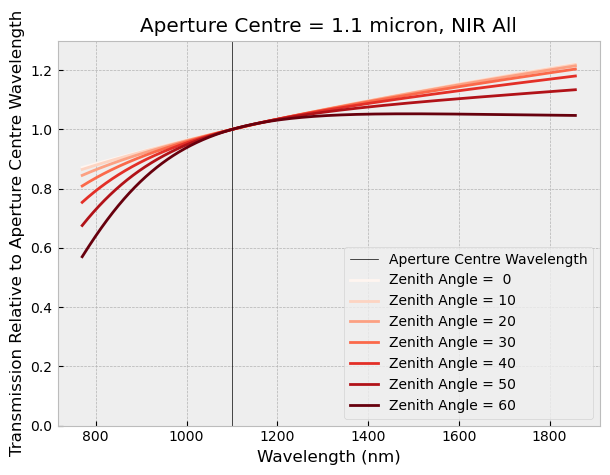

In [38]:
# analysis=AD_analysis()
# analysis.load_wave('LR','VIS','B','B',sampling=1 * u.nm)
# analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])
# analysis.calculate_shifts(fibrecentre_waveref = 0.43 * u.micron,reposition=True, guide_waveref=0.43 * u.micron)
# analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01, beta=2.5)
# conditions=analysis.conditions
# trans_plot2(analysis.input_parameters,analysis.output_parameters,conditions,normalise="centre")

# analysis=AD_analysis()
# analysis.load_wave('LR','VIS','V','V',sampling=1 * u.nm)
# analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])
# analysis.calculate_shifts(fibrecentre_waveref = 0.55 * u.micron,reposition=True, guide_waveref=0.55 * u.micron)
# analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01, beta=2.5)
# trans_plot2(analysis.input_parameters,analysis.output_parameters,conditions,normalise="centre")

analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm)
analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])
analysis.calculate_shifts(fibrecentre_waveref = 1.1 * u.micron,reposition=True, guide_waveref=5 * u.micron)
analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01, beta=2.5)
trans_plot2(analysis.input_parameters,analysis.output_parameters,conditions,normalise="centre")

Zenith Angles Used
Normalised to Reference Wavelength Transmission
Zenith Angles Used
Normalised to Reference Wavelength Transmission
Zenith Angles Used
Normalised to Reference Wavelength Transmission


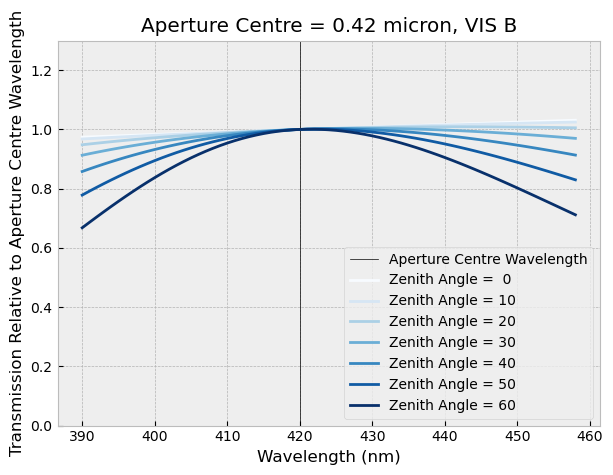

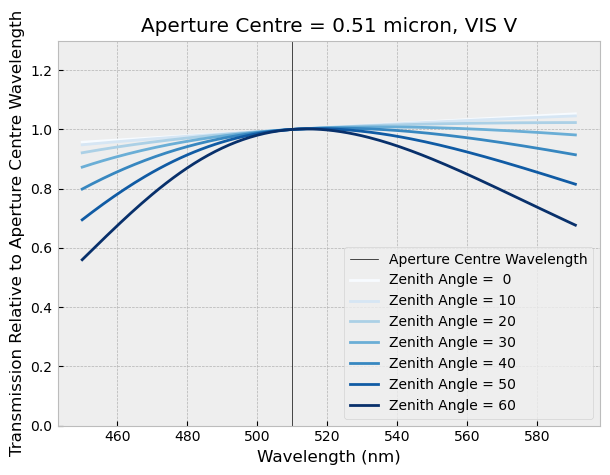

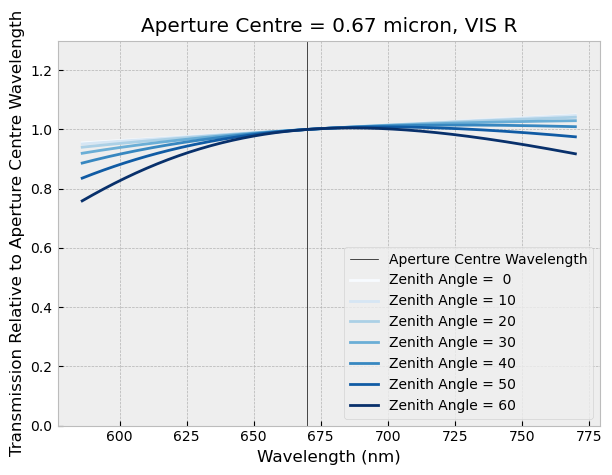

In [35]:
analysis=AD_analysis()
analysis.load_wave('LR','VIS','B','B',sampling=1 * u.nm)
analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])
analysis.calculate_shifts(fibrecentre_waveref = 0.42 * u.micron,reposition=True, guide_waveref=0.42 * u.micron)
analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01, beta=2.5)
trans_plot2(analysis.input_parameters,analysis.output_parameters,conditions,normalise="centre")

analysis=AD_analysis()
analysis.load_wave('LR','VIS','V','V',sampling=1 * u.nm)
analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])
analysis.calculate_shifts(fibrecentre_waveref = 0.51 * u.micron,reposition=True, guide_waveref=0.51 * u.micron)
analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01, beta=2.5)
trans_plot2(analysis.input_parameters,analysis.output_parameters,conditions,normalise="centre")

analysis=AD_analysis()
analysis.load_wave('LR','VIS','R','R',sampling=1 * u.nm)
analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])
analysis.calculate_shifts(fibrecentre_waveref = 0.67 * u.micron,reposition=True, guide_waveref=0.67 * u.micron)
analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01, beta=2.5)
trans_plot2(analysis.input_parameters,analysis.output_parameters,conditions,normalise="centre")

